In [1]:
import os
import numpy as np
import pandas as pd
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from preprocessing_sequencing import preprocess_sequences as ps

%matplotlib inline
import yaml
from collections import Counter
from math import log
from datetime import datetime
from scipy.stats import ttest_rel

In [11]:
#load excel file recording results of non-targeted versus targeted second strand synthesis approach
ssynth = pd.read_excel('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/second_str_synth_results_120122.xlsx')


Paired t-test result: t-statistic = 4.8339, p-value = 0.0084


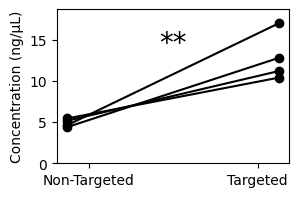

In [67]:
non_targeted = ssynth['Non-targeted']
targeted = ssynth['Targeted']
# Step 2: Conduct a paired t-test
t_stat, p_value_two_tailed = ttest_rel(targeted, non_targeted)
# Adjust for one-tailed p-value
if t_stat > 0:
    p_value_one_tailed = p_value_two_tailed / 2
else:
    p_value_one_tailed = 1 - (p_value_two_tailed / 2)
# Display the t-statistic and p-value
print(f"Paired t-test result: t-statistic = {t_stat:.4f}, p-value = {p_value_one_tailed:.4f}")

plt.figure(figsize=(3, 2))

# X positions for each pair
x_positions = [1, 2]  # '1' for non-targeted, '2' for targeted

# Plot each pair with a line connecting them
for i in range(len(non_targeted)):
    plt.plot(x_positions, [non_targeted[i], targeted[i]], color='black', marker='o', markersize=5)

# Add jitter for better visibility of overlapping points
plt.scatter(np.ones(len(non_targeted)), non_targeted, color='black', label='Non-Targeted')
plt.scatter(np.ones(len(targeted)) * 2, targeted, color='black', label='Targeted')

# Customize plot
plt.xticks([1, 2], ['Non-Targeted', 'Targeted'])
plt.ylabel('Concentration (ng/μL)')

# Draw significance line and asterisk if p-value indicates significance
if p_value_one_tailed < 0.01:
    max_y = max(max(non_targeted), max(targeted))  # Determine the highest y-value for proper asterisk positioning
    #plt.plot([1, 2], [max_y * 1.1, max_y * 1.1], color='black', linestyle='-', linewidth=1)
    plt.text(1.5, max_y*0.8, '**', fontsize=20, ha='center')
plt.ylim(0, max_y * 1.1)
plt.xticks([1.1, 1.9], ['Non-Targeted', 'Targeted'])
plt.show()

In [66]:
max_y * 1.1

18.700000000000003

In [2]:
mice = ['FIAA45.6a', 'FIAA45.6d']
switching_dict = {}
for mouse in mice:
    parameters_path = pathlib.Path(f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    parameters = ps.load_parameters(directory=parameters_path)
    dir_path = pathlib.Path(parameters_path)
    switching_dict[mouse] = ps.combine_switch_tables(
    template_sw_directory=dir_path / "template_switching/analysed_chunks"
)

Starting combining samples into one big file
Starting combining samples into one big file


In [3]:
#combine switching table for both mice
switching_tab = pd.concat([switching_dict['FIAA45.6a'], switching_dict['FIAA45.6d']])

In [4]:
template_switches = switching_tab[switching_tab["different_neurons"] > 1]
# calculate shannon entropy for umi's to see if it might be bias for low complexity sequences
s = lambda i: -sum(f * log(f, 2) for f in ((j / len(i)) for j in Counter(i).values()))
template_switches["entropy"] = template_switches["UMI"].apply(s)
template_switches["relative_abundance"] = (
    template_switches["1st_abundant"] / template_switches["2nd_abundant"]
)
# calculate AT content
AT_calc = lambda x: (x.count("A") + x.count("T")) / len(x)
template_switches["AT_content"] = template_switches["UMI"].apply(AT_calc)

/tmp/ipykernel_2670100/3396120200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  template_switches["entropy"] = template_switches["UMI"].apply(s)
/tmp/ipykernel_2670100/3396120200.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  template_switches["relative_abundance"] = (
/tmp/ipykernel_2670100/3396120200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Text(0.5, 1.0, 'Entropy')

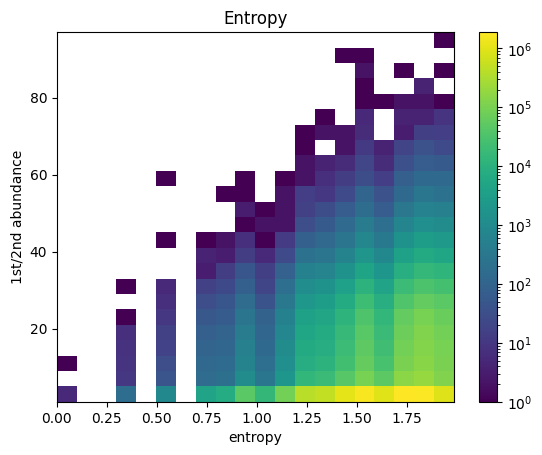

In [32]:
plt.hist2d(
    template_switches["entropy"],
    template_switches["relative_abundance"],
    norm=mpl.colors.LogNorm(),
    bins=(20, np.arange(1, 100, 4)),
)
plt.colorbar()
plt.xlabel("entropy")
plt.ylabel("1st/2nd abundance")
plt.title("Entropy")

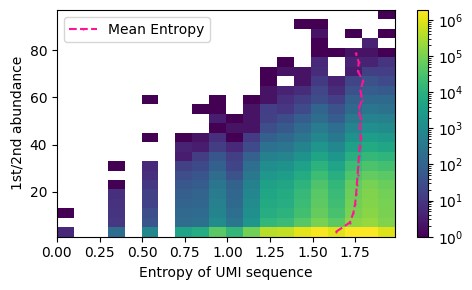

In [58]:
df = pd.DataFrame(template_switches)

# Create a smaller figure size with a single subplot
fig, ax1 = plt.subplots(figsize=(5, 3))

# Main plot: 2D histogram with log normalization
hist = ax1.hist2d(
    df["entropy"],
    df["relative_abundance"],
    norm=mpl.colors.LogNorm(),
    bins=(20, np.arange(1, 100, 4))
)

plt.colorbar(hist[3], ax=ax1)  # Add colorbar for the 2D histogram

ax1.set_xlabel("Entropy of UMI sequence")
ax1.set_ylabel("1st/2nd abundance")
#ax1.set_title("Entropy")

# Compute the median entropy for each bin on the y-axis
y_bins = np.arange(1, 100, 4)

# Digitize the 'relative_abundance' to find bin indices
df['bin'] = np.digitize(df["relative_abundance"], y_bins)

# Group by bin and calculate the count and median entropy
grouped = df.groupby('bin').agg(count=('entropy', 'size'), median_entropy=('entropy', 'mean'))

# Prepare lists to store values to plot
medians_to_plot = []
y_bin_centers = []

# Loop through each bin to check conditions and prepare plotting data
for bin_index, row in grouped.iterrows():
    if row['count'] > 5:  # Only consider bins with 3 or more data points
        y_center = y_bins[bin_index - 1] + np.diff(y_bins)[0] / 2  # Center of the bin
        medians_to_plot.append(row['median_entropy'])
        y_bin_centers.append(y_center)

# Plot the median entropies, aligning with bin centers
ax1.plot(medians_to_plot, y_bin_centers, color='deeppink', markersize=0.5, marker='o', linestyle='--', label='Mean Entropy')

# Add a legend to indicate the median line
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()

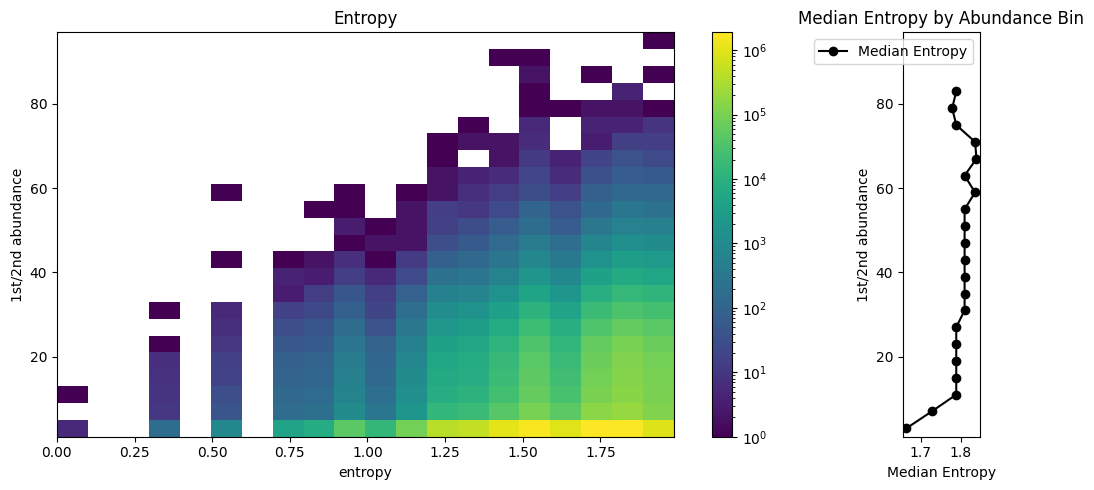

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd

# Assuming template_switches is a dictionary with 'entropy' and 'relative_abundance' keys
# Replace this line with the actual data loading process
# template_switches = {'entropy': [...], 'relative_abundance': [...]}

# Convert data to pandas DataFrame for efficient processing
df = pd.DataFrame(template_switches)

# Create a smaller figure size with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [2, 0.2]})

# Main plot: 2D histogram with log normalization on ax1
hist = ax1.hist2d(
    df["entropy"],
    df["relative_abundance"],
    norm=mpl.colors.LogNorm(),
    bins=(20, np.arange(1, 100, 4))
)

plt.colorbar(hist[3], ax=ax1)  # Add colorbar for the 2D histogram

ax1.set_xlabel("entropy")
ax1.set_ylabel("1st/2nd abundance")
ax1.set_title("Entropy")

# Compute the median entropy for each bin on the y-axis
y_bins = np.arange(1, 100, 4)

# Digitize the 'relative_abundance' to find bin indices
df['bin'] = np.digitize(df["relative_abundance"], y_bins)

# Group by bin and calculate the count and median entropy
grouped = df.groupby('bin').agg(count=('entropy', 'size'), median_entropy=('entropy', 'median'))

# Prepare lists to store values to plot
medians_to_plot = []
y_bin_centers = []

# Loop through each bin to check conditions and prepare plotting data
for bin_index, row in grouped.iterrows():
    if row['count'] >= 5:  # Only consider bins with 3 or more data points
        y_center = y_bins[bin_index - 1] + np.diff(y_bins)[0] / 2  # Center of the bin
        medians_to_plot.append(row['median_entropy'])
        y_bin_centers.append(y_center)

# Side plot: Median entropy line plot on ax2
ax2.plot(medians_to_plot, y_bin_centers, color='black', marker='o', linestyle='-', label='Median Entropy')
ax2.set_xlabel('Median Entropy')
ax2.set_ylabel('1st/2nd abundance')
ax2.set_title('Median Entropy by Abundance Bin')

# Synchronize y-axis between the two plots
ax2.set_ylim(ax1.get_ylim())

# Add a legend to indicate the median line
ax2.legend()

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'AT content of UMI sequence vs Abundance')

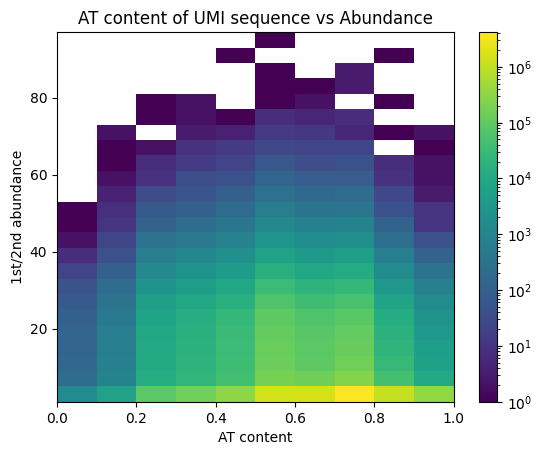

In [10]:
plt.hist2d(
    template_switches["AT_content"],
    template_switches["relative_abundance"],
    norm=mpl.colors.LogNorm(),
    bins=(10, np.arange(1, 100, 4)),
)
plt.colorbar()
plt.xlabel("AT content")
plt.ylabel("1st/2nd abundance")
plt.title("AT content of UMI sequence vs Abundance")

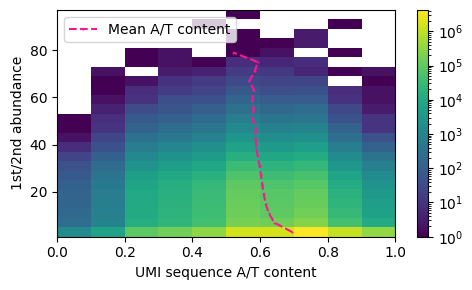

In [59]:
df = pd.DataFrame(template_switches)

# Create a smaller figure size with a single subplot
fig, ax1 = plt.subplots(figsize=(5, 3))

# Main plot: 2D histogram with log normalization
hist = ax1.hist2d(
    df["AT_content"],
    df["relative_abundance"],
    norm=mpl.colors.LogNorm(),
    bins=(10, np.arange(1, 100, 4))
)

plt.colorbar(hist[3], ax=ax1)  # Add colorbar for the 2D histogram

ax1.set_xlabel("UMI sequence A/T content")
ax1.set_ylabel("1st/2nd abundance")
#ax1.set_title("UMI AT content")

# Compute the median entropy for each bin on the y-axis
y_bins = np.arange(1, 100, 4)

# Digitize the 'relative_abundance' to find bin indices
df['bin'] = np.digitize(df["relative_abundance"], y_bins)

# Group by bin and calculate the count and median entropy
grouped = df.groupby('bin').agg(count=('AT_content', 'size'), median_AT_content=('AT_content', 'mean'))

# Prepare lists to store values to plot
medians_to_plot = []
y_bin_centers = []

# Loop through each bin to check conditions and prepare plotting data
for bin_index, row in grouped.iterrows():
    if row['count'] > 5:  # Only consider bins with 3 or more data points
        y_center = y_bins[bin_index - 1] + np.diff(y_bins)[0] / 2  # Center of the bin
        medians_to_plot.append(row['median_AT_content'])
        y_bin_centers.append(y_center)

# Plot the median entropies, aligning with bin centers
ax1.plot(medians_to_plot, y_bin_centers, color='deeppink', markersize=0.5, marker='o', linestyle='--', label='Mean A/T content')

# Add a legend to indicate the median line
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()